# AI Traffic System Recognition System

Description.

## Necessary Packages

In [17]:
!pip install ipywidgets tensorflow opencv-python-headless Pillow pandas numpy matplotlib scikit-learn seaborn

In [18]:
# Importing the packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import ipywidgets as widgets
from IPython.display import display
from PIL import Image
import io

## Data Loading and Preprocessing

I found the GTSRB on Kaggle. Using Kaggle API, I download the data into the notebook.

In [1]:
!pip install kaggle
!kaggle datasets download -d meowmeowmeowmeowmeow/gtsrb-german-traffic-sign

Dataset URL: https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign
License(s): CC0-1.0
100%|████████████████████████████████████████| 612M/612M [00:20<00:00, 37.0MB/s]
100%|████████████████████████████████████████| 612M/612M [00:20<00:00, 30.9MB/s]


Next, the data is extracted:

In [3]:
import zipfile
import os

zip_path = 'gtsrb-german-traffic-sign.zip'
extract_to = 'data'

# Create the directory
os.makedirs(extract_to, exist_ok=True)

# Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print("Extraction Done")

Extraction Done


Preprocessing:

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import cv2

# Define image dimensions (e.g., 32x32)
img_width, img_height = 32, 32

def load_images_and_labels(base_path):
    images = []
    labels = []
    num_classes = 43  # There are 43 classes of traffic signs in the GTSRB dataset

    for folder in range(num_classes):
        path = os.path.join(base_path, str(folder))
        if not os.path.exists(path):
            continue
        for file in os.listdir(path):
            image_path = os.path.join(path, file)
            image = cv2.imread(image_path)
            image = cv2.resize(image, (img_width, img_height))
            images.append(image)
            labels.append(folder)
    
    # Convert lists to numpy arrays and normalize image vectors
    images = np.array(images)
    images = images.astype('float32') / 255.0
    labels = np.array(labels)
    labels = to_categorical(labels, num_classes=num_classes)
    
    return images, labels

def load_test_images_and_labels(base_path, label_file):
    # Load the labels from the CSV file
    label_df = pd.read_csv(label_file)
    images = []
    labels = []
    
    # Iterate over the dataframe rows
    for _, row in label_df.iterrows():
        image_path = os.path.join(base_path, row['Path'])
        image = cv2.imread(image_path)
        if image is not None:
            image = cv2.resize(image, (img_width, img_height))
            images.append(image)
            labels.append(row['ClassId'])
    
    # Convert lists to numpy arrays and normalize image vectors
    images = np.array(images)
    images = images.astype('float32') / 255.0
    labels = np.array(labels)
    # Convert labels to one-hot encoded format
    labels = to_categorical(labels, num_classes=43)
    
    return images, labels

# Extracting the dataset to 'data/train' and 'data/test'
train_images, train_labels = load_images_and_labels('data/train')
test_images, test_labels = load_test_images_and_labels('data', 'data/Test.csv')

print(f"Train images shape: {train_images.shape}")
print(f"Test images shape: {test_images.shape}")
print("Data Loaded and Processed")

Train images shape: (39209, 32, 32, 3)
Test images shape: (12630, 32, 32, 3)
Data Loaded and Processed


Model Building

In [9]:
# Define the model architecture
model = Sequential()

# First convolutional layer
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(img_width, img_height, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Second convolutional layer
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Third convolutional layer
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the convolutional layers to create a fully connected layer
model.add(Flatten())

# Fully connected layer
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

# Output layer (43 classes)
model.add(Dense(43, activation='softmax'))

# Print model summary
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 43)             │         5,547 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 164,459 (642.42 KB)

 Trainable params: 164,459 (642.42 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

## Training

In [11]:
history = model.fit(train_images, train_labels, epochs=15, batch_size=32, validation_data=(test_images, test_labels))


Epoch 1/15
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 19s 14ms/step - accuracy: 0.2844 - loss: 2.6013 - val_accuracy: 0.8407 - val_loss: 0.5762
Epoch 2/15
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - accuracy: 0.8520 - loss: 0.4731 - val_accuracy: 0.9101 - val_loss: 0.3507
Epoch 3/15
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - accuracy: 0.9301 - loss: 0.2217 - val_accuracy: 0.9334 - val_loss: 0.2684
Epoch 4/15
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - accuracy: 0.9573 - loss: 0.1397 - val_accuracy: 0.9372 - val_loss: 0.2409
Epoch 5/15
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - accuracy: 0.9684 - loss: 0.1020 - val_accuracy: 0.9452 - val_loss: 0.2432
Epoch 6/15
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - accuracy: 0.9761 - loss: 0.0776 - val_accuracy: 0.9463 - val_loss: 0.2168
Epoch 7/15
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - accuracy: 0.9777 - loss: 0.0700 - val_accuracy: 0.9409 - val_loss: 0.2458
Epoch 8/15
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accuracy: 0.9808 -

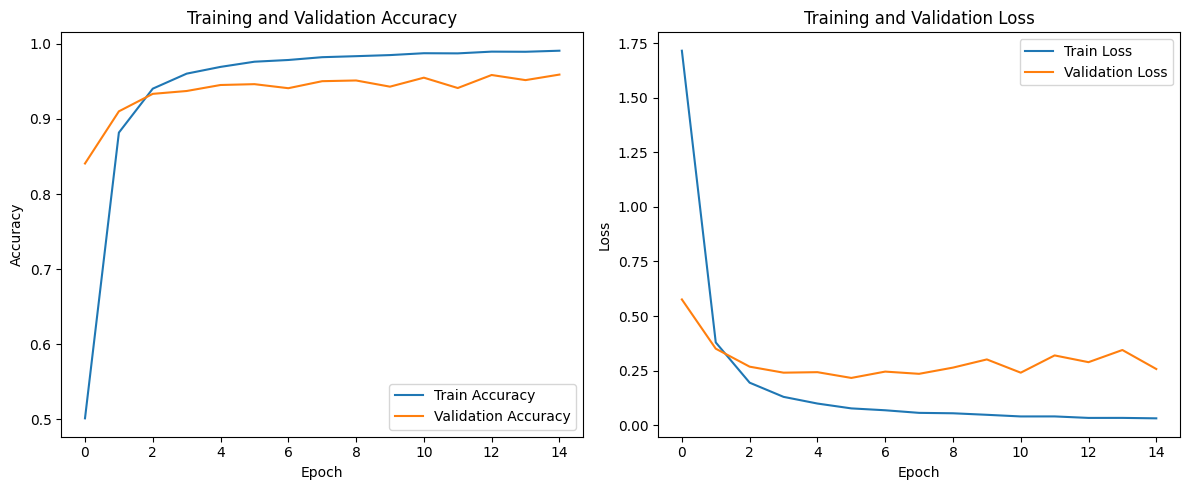

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot training accuracy and validation accuracy
ax1.plot(history.history['accuracy'], label='Train Accuracy')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.set_title('Training and Validation Accuracy')
ax1.legend(loc='lower right')

# Plot training loss and validation loss
ax2.plot(history.history['loss'], label='Train Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.set_title('Training and Validation Loss')
ax2.legend(loc='upper right')

# Display the plots
plt.tight_layout()
plt.show()

## Testing

In [14]:
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print(f"Test accuracy: {test_acc * 100:.2f}%")


395/395 - 2s - 5ms/step - accuracy: 0.9591 - loss: 0.2577
Test accuracy: 95.91%


395/395 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


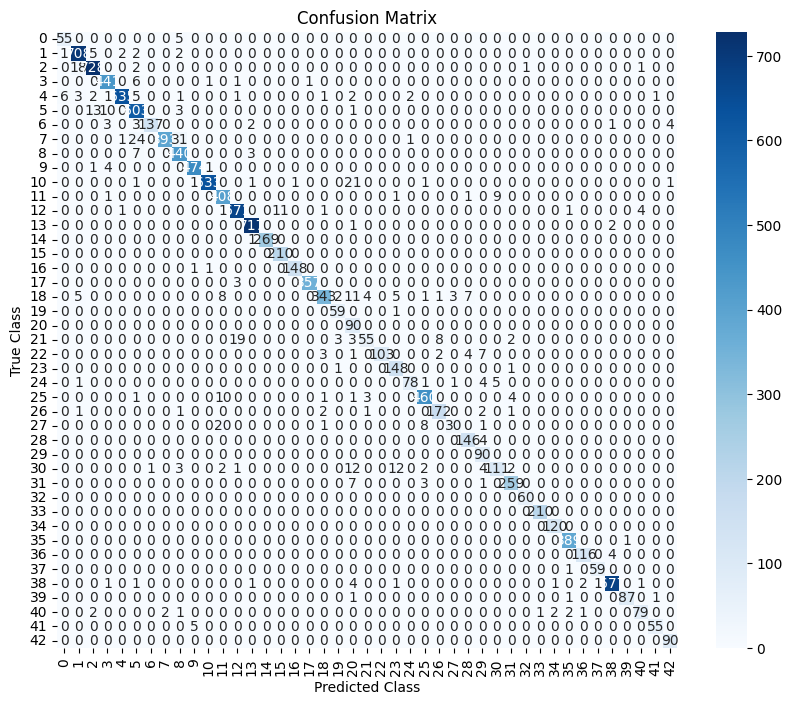

In [19]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get predictions from the model
y_pred = model.predict(test_images)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert one-hot to class labels
y_true = np.argmax(test_labels, axis=1)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()

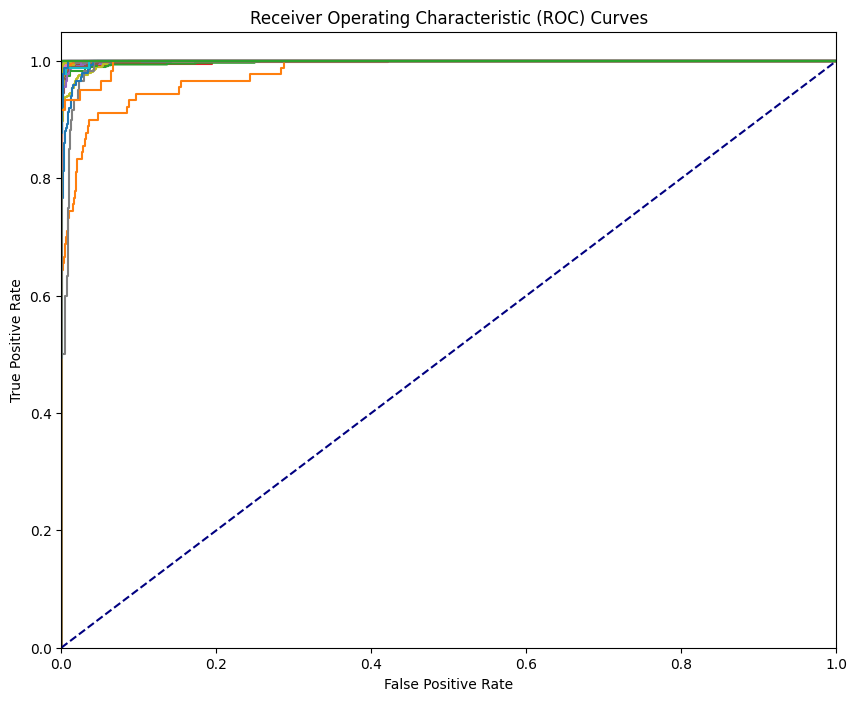

In [21]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

# Binarize the labels for ROC curve (if not already one-hot encoded)
n_classes = 43
y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))

# Plot ROC curves for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(test_labels[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curves
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.show()


In [24]:
from sklearn.metrics import classification_report

# Generate classification report
class_report = classification_report(y_true, y_pred_classes, target_names=[str(i) for i in range(43)])

# Display the classification report in text format
print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.92      0.90        60
           1       0.96      0.98      0.97       720
           2       0.97      0.97      0.97       750
           3       0.96      0.98      0.97       450
           4       0.99      0.96      0.98       660
           5       0.92      0.96      0.94       630
           6       0.99      0.91      0.95       150
           7       0.99      0.87      0.93       450
           8       0.90      0.98      0.94       450
           9       0.99      0.99      0.99       480
          10       1.00      0.96      0.98       660
          11       0.91      0.97      0.94       420
          12       0.96      0.97      0.97       690
          13       0.99      1.00      0.99       720
          14       1.00      1.00      1.00       270
          15       0.95      1.00      0.97       210
          16       0.99      0.99      0.99       150
    

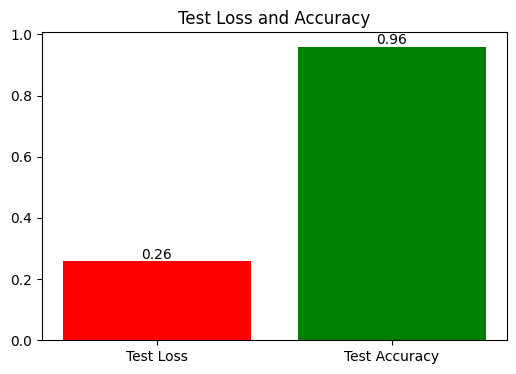

In [25]:
import matplotlib.pyplot as plt

# Test accuracy and loss
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=0)

# Create bar plot
fig, ax = plt.subplots(figsize=(6, 4))
bars = ax.bar(['Test Loss', 'Test Accuracy'], [test_loss, test_acc], color=['red', 'green'])

# Add labels on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

ax.set_title('Test Loss and Accuracy')
plt.show()

### Misclassified Images

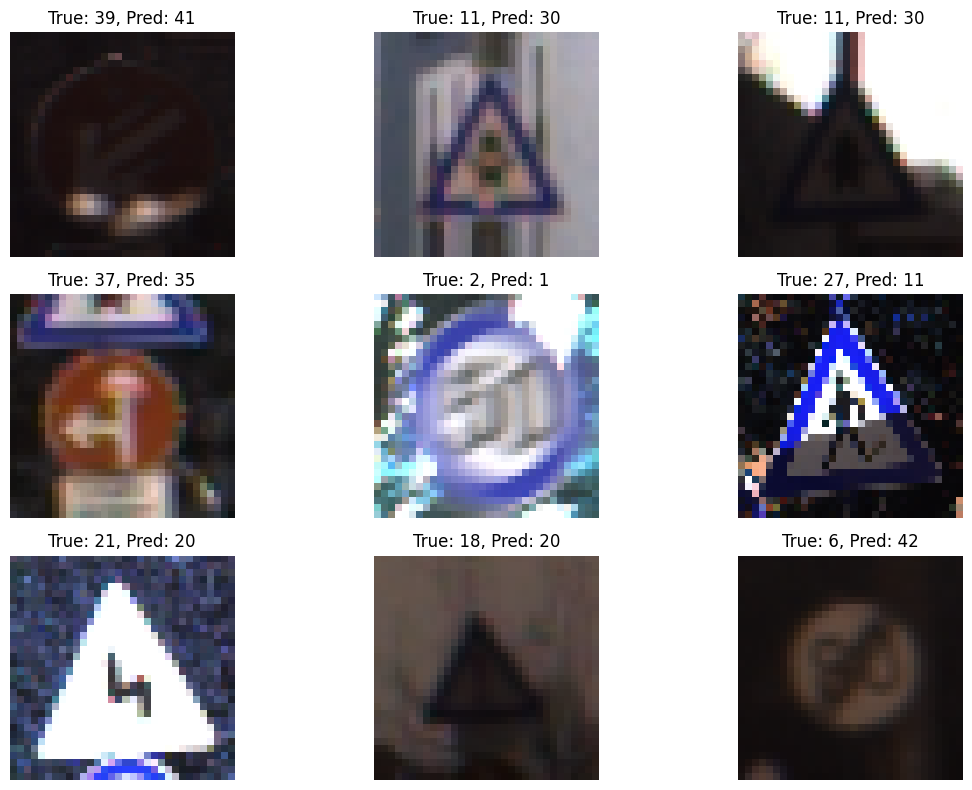

In [31]:
import random

# Identify misclassified examples
misclassified_indices = np.where(y_pred_classes != y_true)[0]

# Shuffle the misclassified indices to get a random selection
random.shuffle(misclassified_indices)

# Plot a variety of misclassified images (you can change the number to display more or fewer images)
plt.figure(figsize=(12, 8))
num_samples = 9  # Display 9 misclassified images
for i, idx in enumerate(misclassified_indices[:num_samples]):
    plt.subplot(3, 3, i + 1)
    plt.imshow(test_images[idx])
    plt.title(f'True: {y_true[idx]}, Pred: {y_pred_classes[idx]}')
    plt.axis('off')

plt.tight_layout()
plt.show()


## Conclusion

## Predictions